Questions:
- Will more than one lens affect source? Seems so at micro-arcsecond precision

# Summary

Use this notebook to generate training data.
- (i) initialize an observer (with or without parallax)
- (ii) randomly sample sources and lenses relative to one another
- (iii) observe the source $N_O$ times, creating a list of celestial coordinates, $[\phi, \theta]_i$.
- (iv) repeat this process $N_t$ times

# Downloads

In [397]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
%autoreload

import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

# Astropy
from astropy import units as u

# lenstools
import lenstools as lt

# Convenient variables
pi   = np.pi
norm = np.linalg.norm
mult = np.matmul
dot  = np.dot

# Parameters

In [399]:
# Don't use Astopy units, for a speedup
units = False

# Training set size
N_t = int(1e5)

In [400]:
# Observer properties

# Number of observations
N_o = 20

# Observation time
t_obs = 5
if units:
    t_obs *= u.yr

# Time increment for observations
dt = t_obs/N_o

# Flag to include parallax or not
#    observer moves along a cirlce of radius 1AU with period 1yr
parallax = True

In [401]:
# Lens properties

# mass parameter of lenses in M_sol
M_l = 1e7

# kind of lens: ['point', 'Gaussian', 'tNFW', 'Burkert']
# Warning: Latter two not implemented yet
kind = 'Gaussian'

# Length scale of lens mass distribution in kpc
R_l = 1e-3

# Length scale of observer-lens distance in kpc
D_ol = 1.

if units:
    M_l *= u.M_sun
    R_l *= u.kpc
    D_ol *= u.kpc

In [402]:
# Source properties

# Length scale of lens-source distance
D_ls = 1.

# Length scale of source impact parameter
D_b = 1.

if units:
    D_ls *= u.kpc
    D_b *= u.kpc

In [403]:
# length scales will be used according to:
#    scale[0] -> uniform distribution of lens distance from observer
#    scale[1] -> uniform distribution of source distance past lens
#    scale[2] -> uniform distribution of source perp distance from 
#                observer-lens axis

scale = [D_ol, D_ls, D_b]

# Example: Lucky Event

Use a reference frame where $z$ is up-down, $x$ is left-right, and $y$ is distance in front or behind. 

So an object straight in front of you (the observer) has only a non-zero $y$ coordinate, and angular coordinates $\theta = \phi = \pi/2$, and $\phi$ will shrink if $x$ grows.

In [404]:
%autoreload
# Create an observer object
obs = lt.Observer(parallax = parallax, units=units)

# Create a Lens that is ~.1 kpc away (in the y-direction), moves
# very fast along the x-axis, and transits over the span of ~5 yrs
lucky_lens = lt.Lens(
    x = np.array([-.05, 100, 0]) * 1e-3,  # in kpc
    v = np.array([2e4, 0, 0]) * (u.km/u.s).to(u.kpc/u.yr),  # in km/s
    kind=kind, M=M_l, R=R_l
) 

# The source is stationary, in the z-y plane, and has a small
# impact parameter (is slightly above the x-y plane)
lucky_src = lt.Source(
    x = np.array([0, 300, 10]) * 1e-3,  # in pc
    v = np.array([0, 0, 0]) * (u.km/u.s).to(u.kpc/u.yr)  # in km/s
)

if units:
    lucky_lens.x *= u.kpc
    lucky_src.x *= u.kpc
    
    lucky_lens.v *= u.kpc/u.yr
    lucky_src.v *= u.kpc/u.yr

In [405]:
# Observe the source without any lensing
res_unlensed = obs.observe(lucky_src)

# Observe the source with lensing
res_lensed = obs.observe(lucky_src, lucky_lens)

# Compare lensed and unlensed observations
if units:
    print('[d\\theta, d\phi]:', (res_lensed-res_unlensed).to(u.mas))
else:
    print('[d\\theta, d\phi]:', (res_lensed-res_unlensed) * u.rad.to(u.mas) * 1e3) 

[d\theta, d\phi]: [-26286.53385684   -394.77436551]


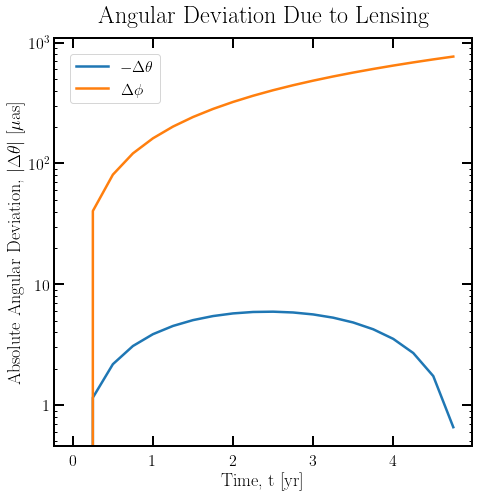

In [406]:
%autoreload
# Now observe multiple times
# Multi-measurements are defined such that \theta_0 and \phi_0
# are subtracted from the list of measurements
# The deviations between lensed/unlensed becomes smaller as a result

res_unlensed = obs.observe(lucky_src, N=N_o, dt=dt)
res_lensed = obs.observe(lucky_src, lucky_lens, N=N_o, dt=dt)

plt.figure(figsize=(7.5,7.5))
# plt.loglog()
plt.yscale('log')

if units:
    times = np.arange(0, t_obs.value, dt.value) * dt.unit
    res = np.array(res_lensed-res_unlensed)
    
else:
    times = np.arange(0, t_obs, dt)
    res = np.array(res_lensed-res_unlensed) * lt.rad_to_muas * 1e-3
    
plt.plot(times, -res[:,0]*1e3, label=r'$-\Delta \theta$')
plt.plot(times, res[:,1]*1e3, label=r'$\Delta \phi$')

plt.xlabel('Time, t [yr]')
plt.ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
plt.title('Angular Deviation Due to Lensing')
plt.legend()

# Example 2: Random Lens and Source

check: set v_scale=0 and see if the parallax is correct.

In [407]:
# If you want to see more than just straight lines,
# observe over longer time intervals
N_o = 20

# Observation time
# t_obs = scale[2]/lt.v_esc
t_obs = 5
if units:
    t_obs *= u.yr
    
# Time increment for observations
dt = t_obs/N_o

Text(0.5, 1.0, 'Impact Parameter Between Source and Lens')

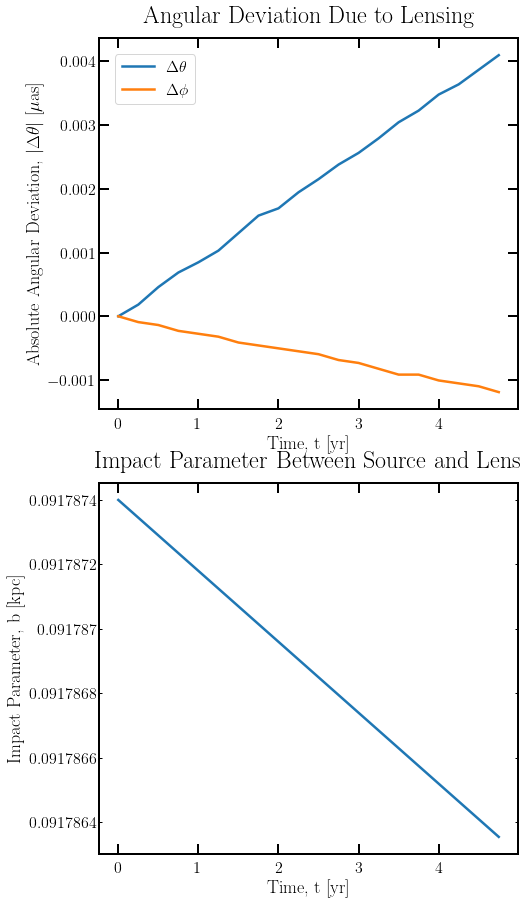

In [408]:
%autoreload

v_scale = lt.v_esc / 5
if units:
    v_scale = v_scale * u.kpc/u.yr

# Try generating a random lens-source pair
lens, src = lt.sample(
    'relative', scale=scale, observer=obs, kind=kind, M=M_l, R=R_l, v_scale=v_scale)

res_unlensed = obs.observe(src, N=N_o, dt=dt)
res_lensed = obs.observe(src, lens, N=N_o, dt=dt)

_, axarr = plt.subplots(2, 1, figsize=(7.5, 15))
# plt.loglog()

if units:
    times = np.arange(0, t_obs.value, dt.value) * dt.unit
    res = np.array(res_lensed-res_unlensed) * 1e3
    
else:
    times = np.arange(0, t_obs, dt)
    res = np.array(res_lensed-res_unlensed) * lt.rad_to_muas
    
axarr[0].plot(times, res[:,0], label=r'$\Delta \theta$')
axarr[0].plot(times, res[:,1], label=r'$\Delta \phi$')

axarr[0].set_xlabel('Time, t [yr]')
axarr[0].set_ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
axarr[0].set_title('Angular Deviation Due to Lensing')
axarr[0].legend()

axarr[1].set_yscale('log')
# axarr[1].plot(times, lt.distance(src, lens, N_o, dt))
axarr[1].plot(times, lt.distance(src, lens, N_o, dt, impact=True, observer=obs))

axarr[1].set_xlabel('Time, t [yr]')
axarr[1].set_ylabel(
    r'Impact Parameter, b [kpc]')
axarr[1].set_title('Impact Parameter Between Source and Lens')

# Generate Single-Blip Training Data

In [409]:
%autoreload
N_t = int(1e5)
N_o = 20
t_obs = 5
dt = t_obs/N_o

In [410]:
# Set the impact parameter scale to something smaller to get 
# more of a signal
scale[2] = 10*1e-3
if units:
    scale[2] *= u.kpc

scale2 = [s for s in scale]

v_esc = lt.v_esc
if units:
    v_esc = v_esc * u.kpc/u.yr

def inv_cdf(p):
    return p

lenses, sources = lt.sample('standard', N_t, scale,
                            inv_cdf, obs, kind, M_l, R_l, 1, v_esc)

Tset = (
    obs.observe(sources, lenses, N=N_o, dt=dt)  # Lensed images
    - obs.observe(sources, N=N_o, dt=dt)  # Unlensed images
) * lt.rad_to_muas

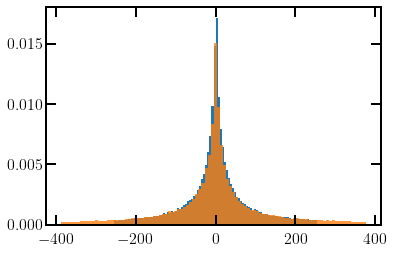

In [411]:
def histo(data, alpha=1.0, color=None):
    a, b = np.histogram(
        data, bins=100, density=True,
        range = (np.quantile(data, .1), np.quantile(data, .9)),
    )
    x = (b[1:] + b[:-1])/2
    b_width = np.diff(b)[0]
    if color is None:
        plt.bar(x, a, b_width, alpha=alpha)
    else:
        plt.bar(x, a, b_width, alpha=alpha, color=color)
    
plt.figure()

histo(Tset[:,-1,0])
histo(Tset[:,-1,1], alpha=0.8)

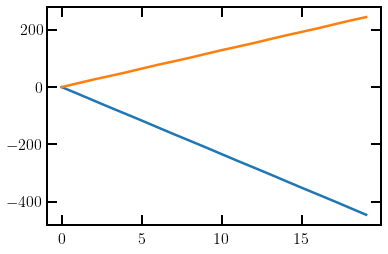

In [412]:
plt.figure()
ind = 50
plt.plot(np.arange(N_o), Tset[ind][:,0])
plt.plot(np.arange(N_o), Tset[ind][:,1])

little wiggles are probably machine precision.  We're looking at micro-arcsecond deflections, meaning 5e-12 deflections.  Somehow we lose an extra 4 orders of magnitude and start running into machine precision problems.

N_0 = 20 fixed, N_t allowed to float

- With units, 1e2 iterations takes about 6.6s.
- Without, 1e3 iterations takes 2.2s (Also stopped using np.linalg.norm function)
- Using Observer.observe on (Sources, Lenses) rather than (Source, Lens), 1e4 iterations takes 2.9s
- Generating lenses and sources using new standard option, 1e5 takes 0.6s

# Generate Multi-Blip Training Data

In [448]:
from astropy.coordinates import SkyCoord
tab = pickle.load(open('/Users/gregoryridgway/Desktop/AstroML/'+
                 'Astrometric_TSeries_ML/data/Gaia_DR2_10kpc_mag10','rb'))

In [449]:
# pclim = 10*u.kpc
# pxlim = pclim.to(u.marcsec, u.parallax())

# mag = 10 # 12

# qry=f"""
# SELECT *
# FROM gaiadr2.gaia_source
# WHERE parallax >= {pxlim.value} AND phot_g_mean_mag <= {mag}
# """

# job = g.launch_job_async(qry)
# tab = job.get_results()

tab['pmra'].unit = 'mas / yr'
tab['pmdec'].unit = 'mas / yr'
tab['radial_velocity'].unit = 'km / s'

mag = np.array(tab['phot_g_mean_mag'])
scnow = SkyCoord(
    tab['ra'], 
    tab['dec'], 
    distance=(np.array(tab['parallax'])*u.mas).to(u.pc, u.parallax())
)

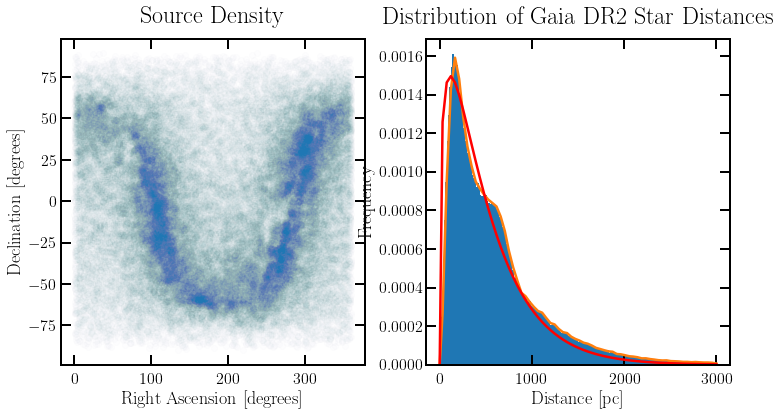

In [512]:
nplots = 2
_, axarr = plt.subplots(1, nplots, figsize=(nplots*6, 6))


### RA and DEC scatter plot ###
axarr[0].scatter(scnow.ra.value[::8], scnow.dec.value[::8], alpha=0.008)
axarr[0].set_xlabel('Right Ascension [degrees]')
axarr[0].set_ylabel('Declination [degrees]')
axarr[0].set_title('Source Density')


### Distance Histogram ###
dmax = 3e3
a,b = np.histogram(scnow.distance.value[scnow.distance.value<dmax], bins=200, density=True)
x = (b[1:] + b[:-1])/2
b_width = np.diff(b)[0]
plt.bar(x, a, b_width)
plt.xlabel('Distance [pc]')
plt.ylabel('Frequency')
plt.title('Distribution of Gaia DR2 Star Distances')


window = 3
data = [[0,0]]
for i in np.arange(0,len(a),window):
    data.append([b[i+2], np.sum(a[i:i+window])/window])

data = np.array(data)

axarr[1].plot(data[:,0], data[:,1], color='C1')
plt.plot(data[:,0], gdist(data[:,0], 1.3, 2.6e-3), color='red')

In [471]:
from scipy.special import gamma

In [474]:
def gdist(x, a, b):
    return b * (b*x)**(a-1) * np.exp(-b*x) / gamma(a)

In [542]:
i2, i1 = 38, 8
def slp(x):
    slope = (np.log(data[i2,1]) - np.log(data[i1,1]))/(data[i2,0] - data[i1,0])
    return  slope * (x-data[i1,0]) + np.log(data[i1,1])

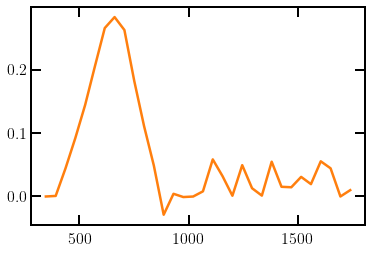

In [544]:
plt.figure()

plt.plot(data[8:40,0], np.log(data[8:40,1])-slp(data[8:40,0]), color='C1')
# plt.plot(data[8:40,0], slp(data[8:40,0]), color='C2')

In [416]:
# Made a histogram of Gaia stars, converted to cdf, inverted it
# x-axis scale is parsec, so we convert
inv_cdf_raw = pickle.load(open('/Users/gregoryridgway/Desktop/AstroML/'+
                          'Astrometric_TSeries_ML/data/Gaia_DR2_inv_cdf', 'rb'))

def inv_cdf(p):
    return inv_cdf_raw(p) * 1e-3  # converts to kpc

In [417]:
%autoreload
lenses, sources = lt.sample('standard', N_t, scale,
                            inv_cdf, obs, kind, M_l, R_l)
# data = obs.observe(sources)

In [418]:
theta0 = np.pi/2/lt.arcsec
sources.mod_angles([theta0-1.6,theta0+1.6], [-0.9,0.9])

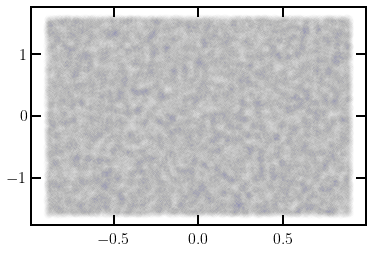

In [419]:
data = obs.observe(sources)
plt.figure()
# mask = np.abs(data[:,1]) < 1
plt.scatter(data[:,1]/lt.arcsec, data[:,0]/lt.arcsec-theta0, alpha=0.004)

In [339]:
data.shape

(100000, 2)

In [455]:
%autoreload
N_spl = 20
N_t = 1000
M_l = 10**np.random.uniform(6, 7, size=N_t)
R_l = 10**np.random.uniform(-3.5, -2.5, size=N_t)
lenses, sources = lt.sample('standard', 1000, scale,
                            inv_cdf, obs, kind, M_l, R_l, N_spl=N_spl)
data = obs.observe(sources, lenses, N=N_o, dt=dt, zeroed=True)

In [466]:
lenses.M[0] = M_hold
tmp = obs.observe(sources, lenses, N=N_o, dt=dt, zeroed=True)

In [462]:
M_hold = lenses.M[0]*1.

In [467]:
tmp[0] - obs.observe(sources[0], N=N_o, dt=dt, zeroed=True)

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.46549439e-14, -3.10862447e-15],
       [ 3.81916720e-14, -1.19904087e-14],
       [ 6.61692923e-14, -3.15303339e-14],
       [ 8.52651283e-14, -4.57411886e-14],
       [ 9.94759830e-14, -4.88498131e-14],
       [ 1.23456800e-13, -5.77315973e-14],
       [ 1.51434421e-13, -7.77156117e-14],
       [ 1.70308212e-13, -9.14823772e-14],
       [ 1.84963156e-13, -9.45910017e-14],
       [ 2.08499884e-13, -1.03472786e-13],
       [ 2.36699549e-13, -1.23456800e-13],
       [ 2.55795385e-13, -1.37223566e-13],
       [ 2.70228284e-13, -1.40332190e-13],
       [ 2.93765012e-13, -1.49213975e-13],
       [ 3.21742633e-13, -1.69197989e-13],
       [ 3.41060513e-13, -1.82964754e-13],
       [ 3.55271368e-13, -1.86073379e-13],
       [ 3.78808096e-13, -1.94955163e-13],
       [ 4.07007761e-13, -2.14939178e-13]])

In [460]:
tmp[0]

array([[ 0.00000000e+00,  0.00000000e+00],
       [-2.27343122e-09,  3.41234654e-08],
       [-4.54685289e-09,  6.82469272e-08],
       [-6.82027013e-09,  1.02370380e-07],
       [-9.09369624e-09,  1.36493841e-07],
       [-1.13671266e-08,  1.70617314e-07],
       [-1.36405474e-08,  2.04740785e-07],
       [-1.59139635e-08,  2.38864246e-07],
       [-1.81873887e-08,  2.72987715e-07],
       [-2.04608182e-08,  3.07111197e-07],
       [-2.27342383e-08,  3.41234675e-07],
       [-2.50076535e-08,  3.75358145e-07],
       [-2.72810778e-08,  4.09481622e-07],
       [-2.95545066e-08,  4.43605113e-07],
       [-3.18279256e-08,  4.77728600e-07],
       [-3.41013402e-08,  5.11852078e-07],
       [-3.63747636e-08,  5.45975563e-07],
       [-3.86481913e-08,  5.80099062e-07],
       [-4.09216097e-08,  6.14222557e-07],
       [-4.31950233e-08,  6.48346044e-07]])

In [427]:
tmp = data.reshape(N_t, N_spl, N_o, 2)

What's the source density?  That should tell us sources per lens (N_spl)

How do we make the training set? 
- Make a full sky set of lenses and sources, then make groups of N_g (say 5) sources

Things to do:

ML-side
- predict lens properties: posterior on mass and size of lens

make the simulation more realistic
- 